# Point72 Global Futures Analysis

Diego Alvarez <br> diego.alvarez@colorado.edu

# Background

Rather than creating an object and then methods for the object functions will be defined as problems / tasks occur so that the flow of the notebook is easier to follow

# Packages

In [171]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

np.random.seed(123)

# Accessing Data

## Path Management

In [3]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
price_path = os.path.join(data_path, "prices.parquet")
price_sample_path = os.path.join(data_path, "prices_sample.parquet")

## Reading in Data

In [4]:
try: df_price = pd.read_parquet(path = price_path, engine = "pyarrow")
except: df_price = pd.read_parquet(path = price_sample_path, engine = "pyarrow") 

# Metadata

Check for duplicates 

In [16]:
def check_duplicates(df: pd.DataFrame):

    df_duplicates = (df.groupby(
        ["contract_name", "local_time"]).
        agg("count").
        reset_index().
        melt(id_vars = ["contract_name", "local_time"]).
        query("value != 1"))

    if len(df_duplicates) == 0: print("No Duplicates Detected")
    else: print("Duplicates Detected")
    
check_duplicates(df_price)

No Duplicates Detected


Look at data count in total with start and stop

In [21]:
def get_count(df: pd.DataFrame):

    display(df[
        ["contract_name", "local_time"]].
        groupby(["contract_name"]).
        agg(["min", "max", "count"])
        ["local_time"])
    
get_count(df_price)

,min,max,count
contract_name,,,
Chicago1,2013-01-01 00:00:00,2022-12-31 18:00:00,1051585
Frankfurt1,2013-01-01 01:00:00,2022-12-31 23:55:00,1051524
London1,2013-01-01 00:00:00,2022-12-31 23:55:00,1051536
NYC1,2013-01-01 00:00:00,2022-12-31 19:00:00,1051597
Tokyo1,2013-01-01 09:00:00,2022-12-31 23:55:00,1051548


Ensuring that there are 250 trading days per each year

In [42]:
def check_open_trade_day(df: pd.DataFrame):

    df_count = (df[
        ["contract_name", "date", "market_day"]].
        drop_duplicates().
        assign(year = lambda x: x.date.dt.year).
        groupby(["contract_name", "year", "market_day"]).
        agg("count")
        ["date"].
        reset_index().
        query("market_day == 'open'").
        query("date != 250"))
    
    if len(df_count) == 0: print("250 trading days present every year of every contract")
    else: print("There are not 250 trading days persent every year of every contract")

check_open_trade_day(df_price)

250 trading days present every year of every contract


# Exploratory Data Analysis

Simply plot the data and account for the various contracts as they get rolled. In this case use close as the price. Due to the computational strain of plotting 5 min bars for 10yrs the data will be resampled with the first price of each day

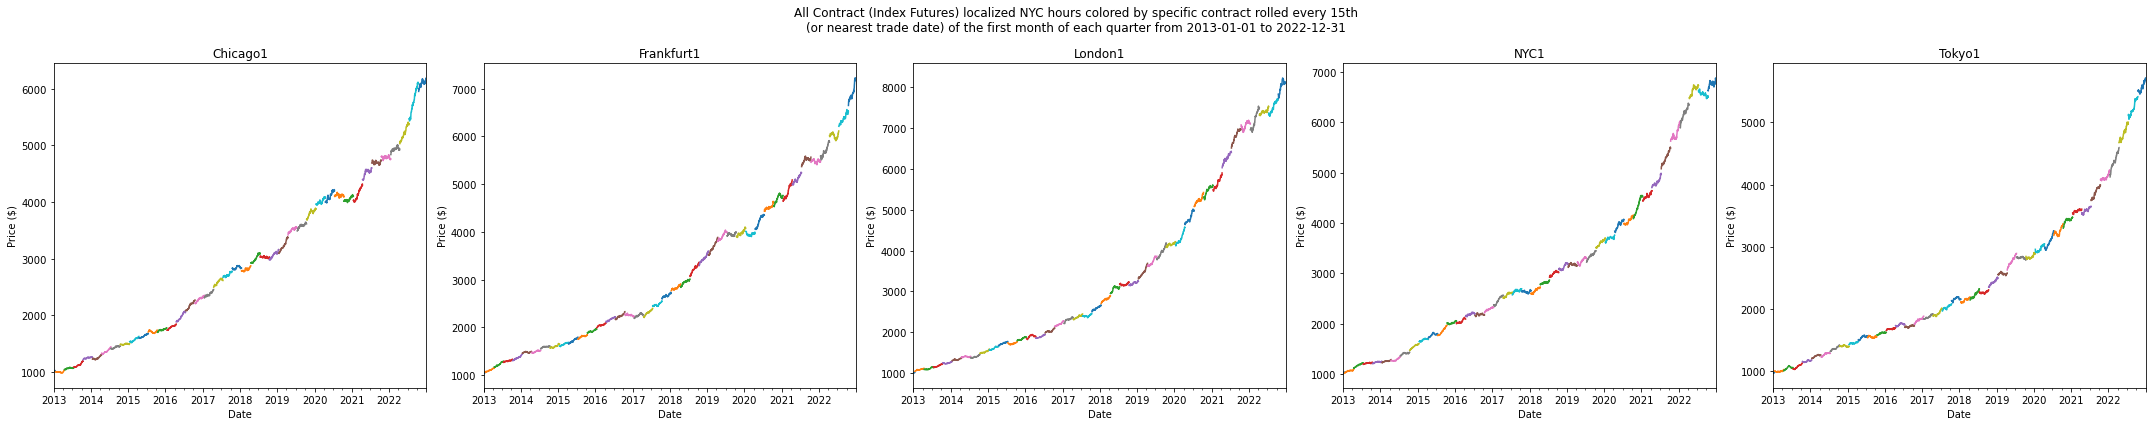

In [191]:
def plot_close_with_roll(df_price: pd.DataFrame):

    contract_names = df_price.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contract_names), figsize = (30,6))

    for i, contract_name in enumerate(contract_names):

        df_tmp = (df_price.query(
            "contract_name == @contract_name").
            set_index("nyc_time").
            resample("D").
            first())

        contracts = df_tmp.contract.drop_duplicates().to_list()
        for contract in contracts:

            (df_tmp.query(
                "contract == @contract")
                [["close_price"]].
                plot(
                    ax = axes[i],
                    legend = False,
                    title = "{}".format(contract_name),
                    xlabel = "Date",
                    ylabel = "Price ($)"))

    fig.suptitle("All Contract (Index Futures) localized NYC hours colored by specific contract rolled every 15th\n(or nearest trade date) of the first month of each quarter from {} to {}".format(
        df_price.date.min().date(),
        df_price.date.max().date()))
    plt.tight_layout()
    plt.show()

plot_close_with_roll(df_price)

Grab a sample monday and plot OHLC bars

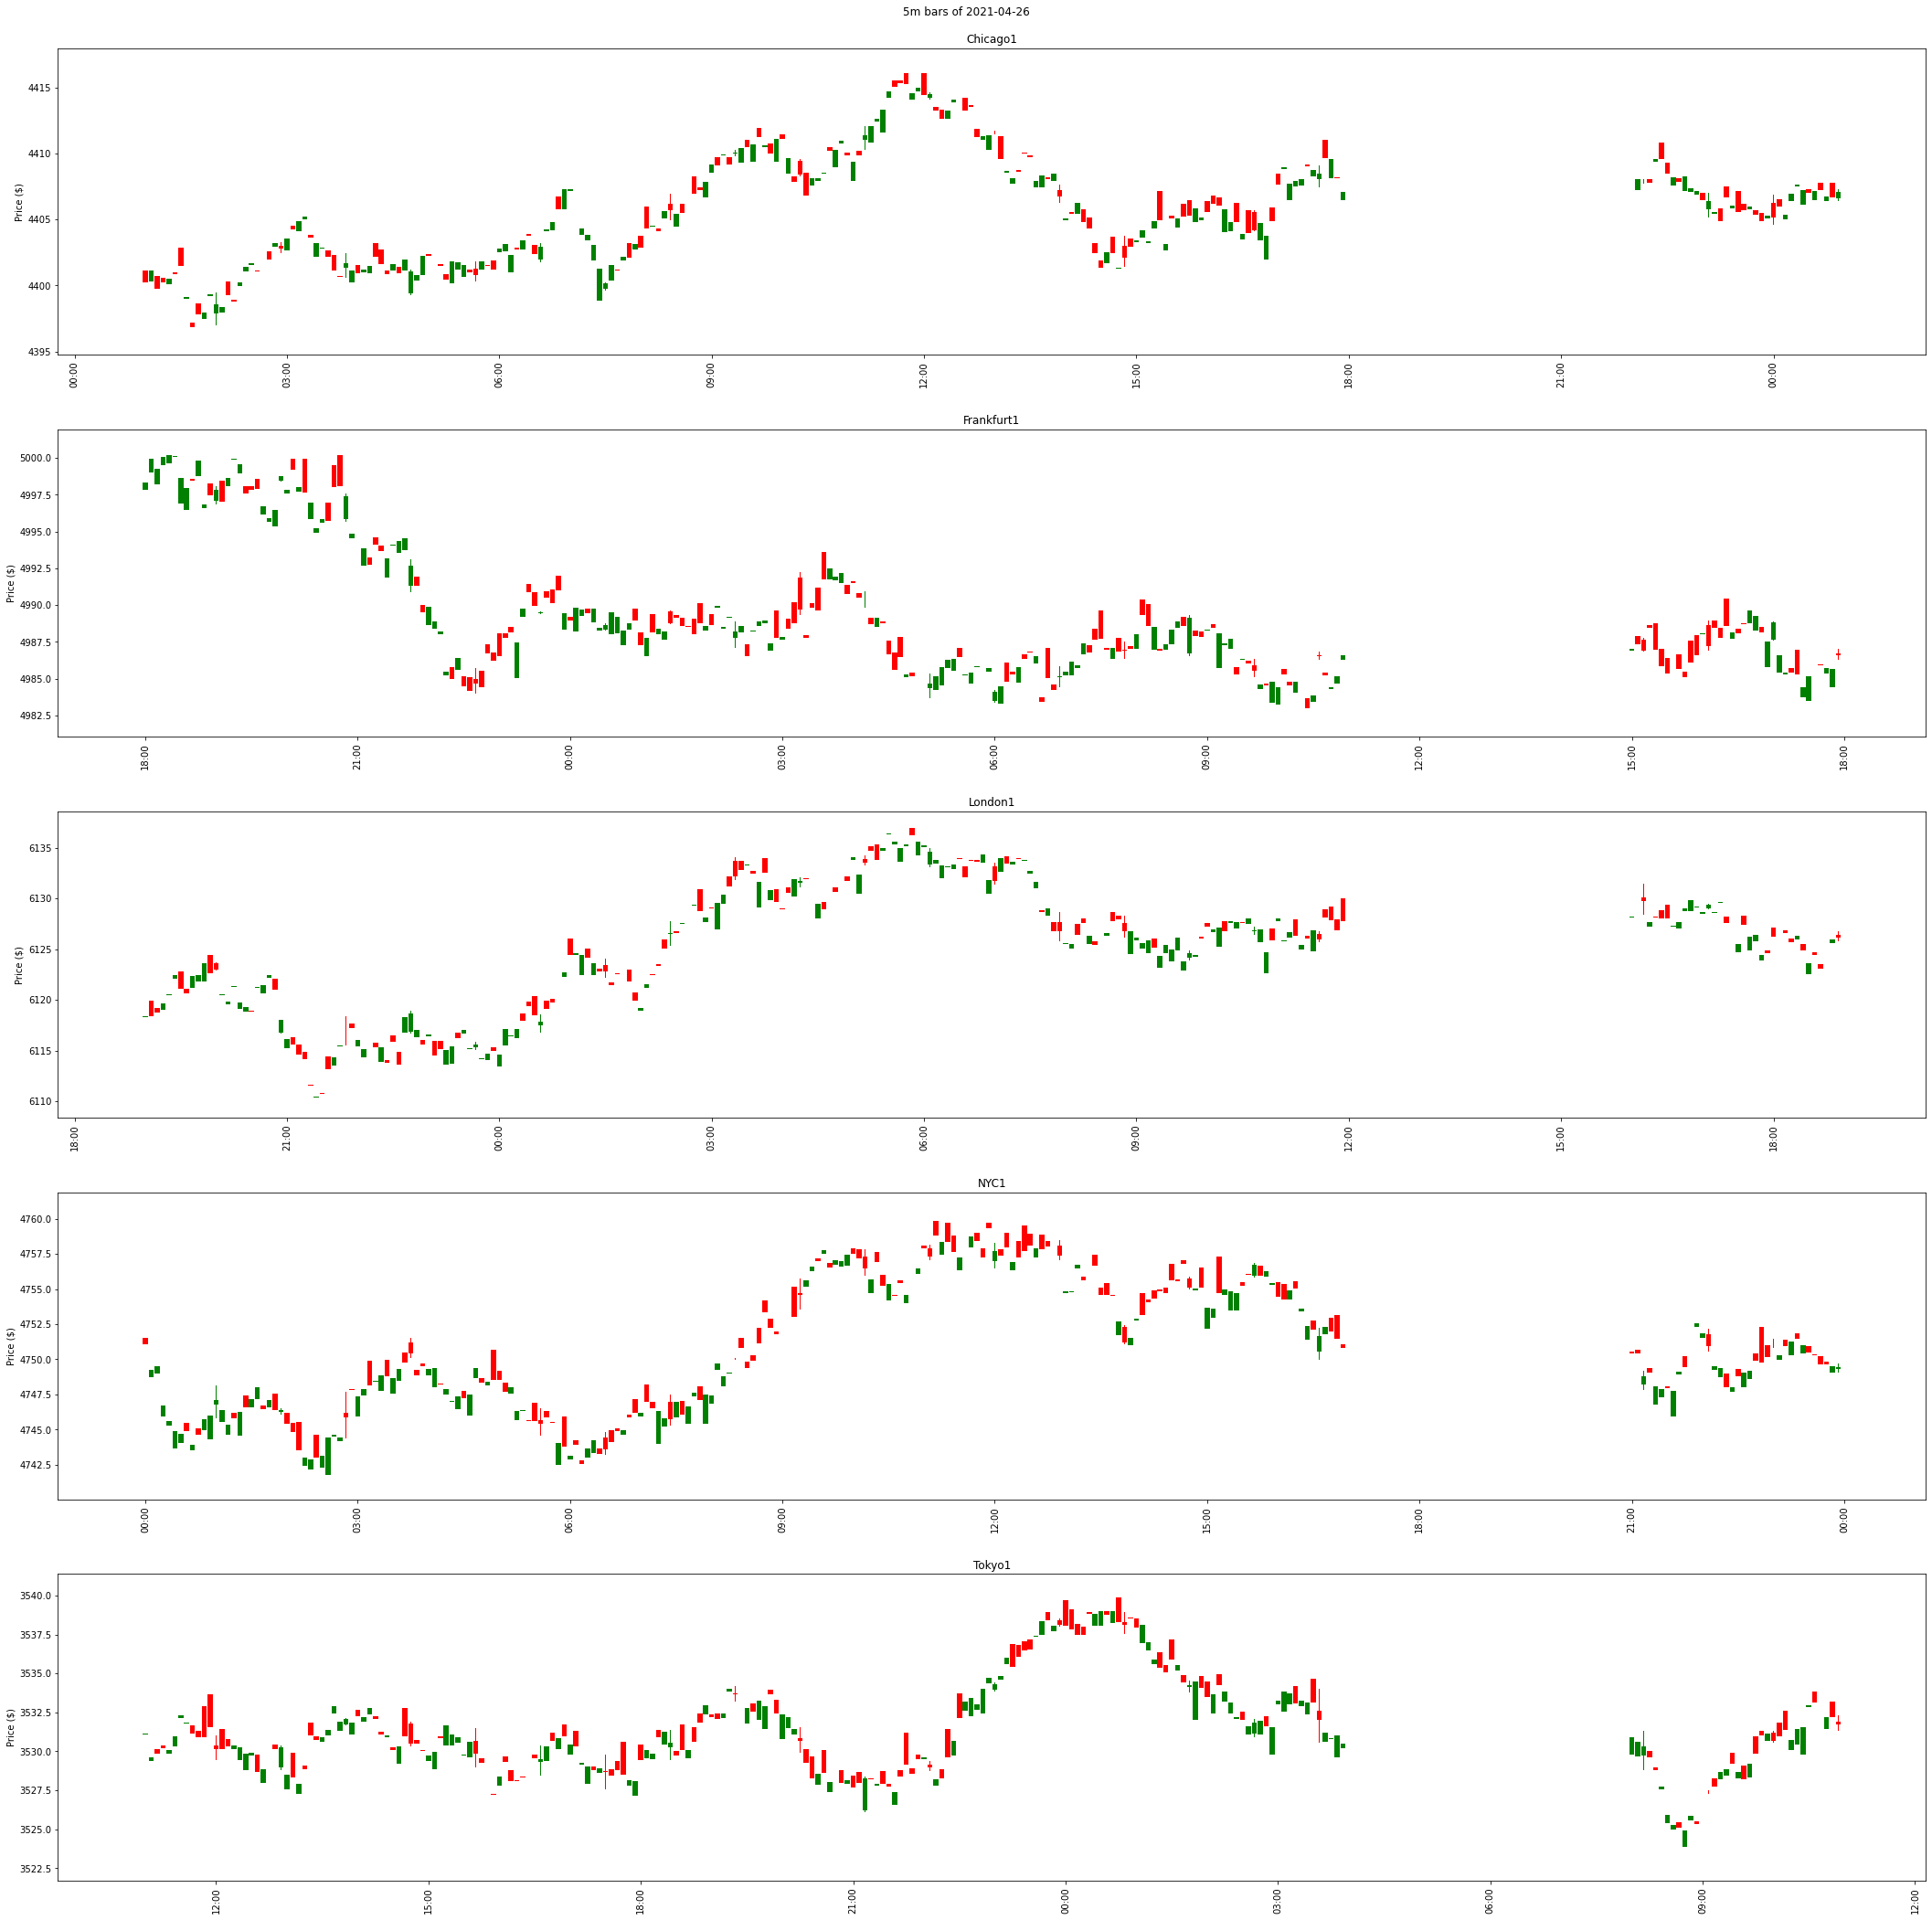

In [190]:
def plot_bars(df_price: pd.DataFrame):

    rand_monday = df_price.query("weekday == 0").date.sample(frac = 1, random_state = 1234).iloc[0].date()

    df_tmp = (df_price.query(
        "date == @rand_monday").
        query("market_hour == 'open'")
        [["nyc_time", "contract_name", "open_price", "high_price", "low_price", "close_price"]])

    contracts = df_tmp.contract_name.drop_duplicates().to_list()

    fig, axes = plt.subplots(nrows = len(contracts), figsize = (30,30))

    for i, contract in enumerate(contracts):

        df_bar = (df_tmp.query(
            "contract_name == @contract").
            drop(columns = ["contract_name"]).
            set_index("nyc_time"))

        df_up = df_bar.query("close_price > open_price")
        df_down = df_bar.query("close_price < open_price")

        width1 = 0.003
        width2 = 0.00003

        axes[i].bar(df_up.index, df_up.close_price - df_up.open_price, width1, bottom = df_up.open_price, color = "red")
        axes[i].bar(df_up.index, df_up.high_price - df_up.close_price, width2, bottom = df_up.close_price, color = "red") 
        axes[i].bar(df_up.index, df_up.low_price - df_up.open_price, width2, bottom = df_up.open_price, color = "red") 

        axes[i].bar(df_down.index, df_down.close_price - df_down.open_price, width1, bottom = df_down.open_price, color = "green")
        axes[i].bar(df_down.index, df_down.high_price - df_down.open_price, width2, bottom = df_down.open_price, color = "green") 
        axes[i].bar(df_down.index, df_down.low_price - df_down.close_price, width2, bottom = df_down.close_price, color = "green") 

        axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        axes[i].tick_params(axis = "x", rotation = 90)
        axes[i].set_title(contract)
        axes[i].set_ylabel("Price ($)")

    fig.suptitle("5m bars of {}".format(rand_monday))
    plt.tight_layout(pad = 3)
    plt.show()
    
plot_bars(df_price)

# Calculations

## Rolling Adjusted Close

In [198]:
df_price.query("contract_name == 'Chicago1'")[["local_time", "contract", "close_price"]].assign(contract = lambda x: x.contract.str.split("_").str[1])

,local_time,contract,close_price
1051797,2013-01-01 00:00:00,1,1005.989000
1051798,2013-01-01 00:05:00,1,1004.473010
1051799,2013-01-01 00:10:00,1,1005.959504
1051800,2013-01-01 00:15:00,1,1005.534260
1051801,2013-01-01 00:20:00,1,1005.189812
...,...,...,...
2103377,2022-12-31 17:40:00,41,6168.571427
2103378,2022-12-31 17:45:00,41,6168.571427
2103379,2022-12-31 17:50:00,41,6168.571427
2103380,2022-12-31 17:55:00,41,6168.571427
